In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import math

from gurobipy import GRB
from utils import file_reader as fr
from utils import data_generator as dg
from utils import data_visualizer as dv


# First MSSP-PD(NQP) example

In this notebook we'll focus on the MSPP-PD version that penalize node-specific path conflict in relation to the number of potential interactions between agents (i.e. the version that invoke node quadratic penalties (__NQP__)).

In the following we'll formulate and solve MSPP-PD(NQP)


## Read data

In this section we read the file containing the netwoork instance that we'll use to solve the MSPP.  
The instance is the same as the MSPP and MSPP-PD(ABP) cases


In [2]:
synthetic_5x5_df = fr.read_networks_csv("data/d_it_ij_5x5_1it.csv",
                                        along="cols")

# show some arcs with related weights of the network
synthetic_5x5_df.T.head()


it1
0 5  3.0
  6  1.0
1 5  1.0
  6  1.0
  7  1.0

## Manage data

In this section we define the variables that we'll use to formulate and solve the MSPP-PD(NQP) problem starting from the dataframe containing the network instance


In [3]:
# nodes in the network
nodes = dg.get_nodes(synthetic_5x5_df)
network_shape = (5,5)
nodes_grid = np.array(nodes).reshape(network_shape).T


# weighted arcs in the network
# the weight of each arc represents the ditance between 2 nodes
w_arcs = [dg.WArc(i, j, synthetic_5x5_df.loc["it1", (i, j)], idx)
          for idx, (i, j) in enumerate(synthetic_5x5_df.columns)]


# agets that has to be routed
agents_sources = [0, 2, 3, 4]
agents_terminus = [20, 22, 23, 24]
agents_idxs = [0, 1, 2, 3]
agents = [dg.Agent(s, t, idx) for s, t, idx in zip(
    agents_sources, agents_terminus, agents_idxs)]


## Problem formulation and solution

In this section we formulate and solve the MSPP-PD(NQP) problem using Gurobi.  
The formulations follows the one reported in section 2.5 of the paper


Create the problem


In [4]:
MSPP_PD_NQP_pb = gb.Model("First MSPP_PD_NQP_pb")
# MSPP_PD_NQP_pb.setParam("OutputFlag", 0)


Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-10


Define decision variables


In [5]:
X_var_shape = len(w_arcs), len(agents)
R_var_shape = len(nodes), len(agents)
W_var_shape = len(nodes), len(agents), len(agents)


X = MSPP_PD_NQP_pb.addMVar(X_var_shape,
                           vtype=GRB.BINARY,  # 5) Binary constraints
                           name="X")

R = MSPP_PD_NQP_pb.addMVar(R_var_shape,
                           vtype=GRB.BINARY,  # 13) Binary constraints
                           name="R")

W = MSPP_PD_NQP_pb.addMVar(W_var_shape,
                           vtype=GRB.BINARY,  # 33) Non-negativity constraints
                           name="W")


Define the 2 objective functions (distance and penalty)


In [6]:
# Weights for the 2 objectives
w_p = 0.5
w_d = 1-w_p


# 1:3, 28) Objective functions
distance_obj = gb.quicksum(
    arc.w * X[arc.idx, agent.idx]
    for arc in w_arcs for agent in agents
)
penalty_obj = gb.quicksum(  # linearized version
    W[node, agent.idx, agent_.idx] for node in nodes
    for agent in agents for agent_ in agents if agent_.idx < agent.idx
)


# as result objective will be: f(X, Psi) = w_d**distance_obj(X) + w_p*penalty_obj(W)
MSPP_PD_NQP_pb.setObjectiveN(distance_obj, index=0, weight=w_d,
                             name="Distance")
MSPP_PD_NQP_pb.setObjectiveN(penalty_obj, index=1, weight=w_p,
                             name="Penalty")


Add constraints


In [7]:
# 4) Flow constraints

def compute_flow(X, node, w_arcs, agent):
    """Compute the flow in a node of a network for a given agent that traverse it

    Args:
        X (gb.MVar): X decision variables of a MSPP or MSPP-PD problem
        node (int): the node on which compute the flow
        w_arcs (list): list of WArc that compose the network
        agent (Agent): the agent for which to calculate the flow

    Returns:
        gb.MLinExpr: linear matrix expression that represent the flow for the agent in the node
    """

    flow_out = gb.quicksum(
        X[arc.idx, agent.idx]
        for arc in w_arcs if arc.i == node
    )
    flow_in = gb.quicksum(
        X[arc.idx, agent.idx]
        for arc in w_arcs if arc.j == node
    )
    return flow_out - flow_in


for agent in agents:
    for node in nodes:
        if node == agent.source:
            MSPP_PD_NQP_pb.addConstr(compute_flow(X, node, w_arcs, agent) == 1)
        elif node == agent.terminus:
            MSPP_PD_NQP_pb.addConstr(
                compute_flow(X, node, w_arcs, agent) == -1)
        else:
            MSPP_PD_NQP_pb.addConstr(compute_flow(X, node, w_arcs, agent) == 0)


In [8]:
# 10,11) Turning on r_i constraints
for arc in w_arcs:
    for agent in agents:
        MSPP_PD_NQP_pb.addConstr(
            R[arc.i, agent.idx] >= X[arc.idx, agent.idx]
        )
        MSPP_PD_NQP_pb.addConstr(
            R[arc.j, agent.idx] >= X[arc.idx, agent.idx]
        )


In [9]:
# 29) Turning off r_i constraints
for node in nodes:
    for agent in agents:
        MSPP_PD_NQP_pb.addConstr(
            R[node, agent.idx] <= (
                gb.quicksum(X[arc.idx, agent.idx] for arc in w_arcs if arc.i == node) +
                gb.quicksum(X[arc.idx, agent.idx]
                            for arc in w_arcs if arc.j == node)
            )
        )


In [10]:
# 30-32) Well-defined W variable
for node in nodes:
    for agent in agents:
        for agent_ in agents:
            if agent_.idx < agent.idx:
                MSPP_PD_NQP_pb.addConstr(
                    W[node, agent.idx, agent_.idx] <= R[node, agent.idx]
                )
                MSPP_PD_NQP_pb.addConstr(
                    W[node, agent.idx, agent_.idx] <= R[node, agent_.idx]
                )
                MSPP_PD_NQP_pb.addConstr(
                    W[node, agent.idx, agent_.idx] >=
                    R[node, agent.idx] + R[node, agent_.idx] - 1
                )


Solve the problem


In [11]:
MSPP_PD_NQP_pb.optimize()


Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1066 rows, 708 columns and 2814 nonzeros
Model fingerprint: 0x6cf369bf
Variable types: 0 continuous, 708 integer (708 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 3e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives (1 combined) ...
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (weighted) ...
---------------------------------------------------------------------------

Optimize a model with 1066 rows, 7

## Report results

In this section we report the results that we've obtained


In [12]:
print("Result of the optimization is:")
if MSPP_PD_NQP_pb.Status == 2:
    print("optimal")
elif MSPP_PD_NQP_pb.Status == 3:
    print("infeasible")
elif MSPP_PD_NQP_pb.Status == 5:
    print("unbounded")
else:
    print("Some other return status")


Result of the optimization is:
optimal


In [13]:
n_objectives = MSPP_PD_NQP_pb.NumObj

print("Optimal solution is such that:")
obj_tot_value = 0
for obj_n in range(n_objectives):
    MSPP_PD_NQP_pb.params.ObjNumber = obj_n
    obj_tot_value = obj_tot_value + MSPP_PD_NQP_pb.ObjNWeight*MSPP_PD_NQP_pb.ObjNVal
    print(f" {MSPP_PD_NQP_pb.ObjNName}={MSPP_PD_NQP_pb.ObjNVal} ", end="|")
print(f" Weighted Total={obj_tot_value}")

Optimal solution is such that:
 Distance=17.0 | Penalty=1.0 | Weighted Total=9.0


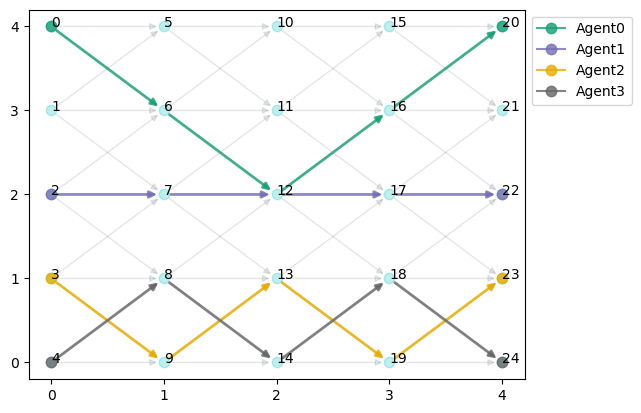

In [14]:
dv.plot_solution(X.x, nodes_grid, w_arcs, agents)


## Explore Pareto solutions

In this section we analize a scenario on which the decision-maker is interested in minimizing both distance and penalty objective function, but their relative priorities are not known a priori.  
In this case is of interest to identify the non-dominated solutions on the Pareto frontier such that the decision-maker can select its priorities a posteriori via the identification of a preferred solution


In [15]:
def evaluate_pb_objectives(problem):
    """Get optimal objectives from an optimization problem

    Args:
        problem (gb.Model): The optimization problem

    Returns:
        list: a list with the optimal values of the different problem's objectives
    """

    assert problem.Status == GRB.Status.OPTIMAL

    problem.params.SolutionNumber = 0  # Set best solution found
    opt_solution = []

    # Add to opt_solution the value of each objective
    for obj in range(problem.NumObj):
        problem.params.ObjNumber = obj
        opt_solution.append(problem.ObjNVal)

    return opt_solution


Create the range of weights to test


In [16]:
w_p_start, w_p_stop, delta = 0.01, 1, 0.01

w_p_range = np.arange(w_p_start, w_p_stop, delta)


Compute solutions to MSPP-PD(NQP) for different weights


In [17]:
MSPP_PD_NQP_pb.setParam("OutputFlag", 0)

opt_distance_values, opt_penalty_values = [], []
prev_opt_distance, prev_opt_penalty = math.nan, math.nan  # initialization values

opt_solutions = []

# Optimal solutions will remain the same for a certain interval of weights of the 2 objectives
w_p_intervals_start, w_p_intervals_stop = [], []


# actual computations
for w_p in w_p_range:

    w_d = 1 - w_p

    # Discard previous solutions
    MSPP_PD_NQP_pb.reset()

    # Change weights of the 2 objectives
    MSPP_PD_NQP_pb.setObjectiveN(
        distance_obj, index=0, weight=w_d, name="Distance")
    MSPP_PD_NQP_pb.setObjectiveN(
        penalty_obj, index=1, weight=w_p, name="Penalty")

    # Optimizing and retrieving new solutions for the new set of weights
    MSPP_PD_NQP_pb.optimize()
    opt_distance, opt_penalty = evaluate_pb_objectives(MSPP_PD_NQP_pb)

    # Check if changing the weights change the opt solution
    if not math.isclose(opt_distance, prev_opt_distance) or not math.isclose(opt_penalty, prev_opt_penalty):  # true if nan

        opt_distance_values.append(opt_distance)
        opt_penalty_values.append(opt_penalty)
        opt_solutions.append(X.x)
        w_p_intervals_start.append(w_p)

        prev_opt_distance, prev_opt_penalty = opt_distance, opt_penalty


Compute the end of intervals wherein solution does not change and the intervals themselves

In [18]:
w_p_intervals_start.append(w_p_stop)
w_p_intervals_stop = [w_p - delta for w_p in w_p_intervals_start]
del w_p_intervals_start[-1], w_p_intervals_stop[0]
w_p_intervals = list(zip(w_p_intervals_start, w_p_intervals_stop))
w_p_intervals


[(0.01, 0.2), (0.21000000000000002, 0.54), (0.55, 0.99)]

### Report results

Objective functions at the optimum for different weights intervals


In [19]:
pareto_results_df = pd.DataFrame(
    {
        "w_p interval": w_p_intervals,
        "Optimal distance": opt_distance_values,
        "Optimal penalty": opt_penalty_values
    }
)
pareto_results_df


,w_p interval,Optimal distance,Optimal penalty
0,"(0.01, 0.2)",16.0,5.0
1,"(0.21000000000000002, 0.54)",17.0,1.0
2,"(0.55, 0.99)",18.2,0.0


Optimal agents' paths for different weights intervals


In [20]:
for x_opt, w_p_interval in zip(opt_solutions, w_p_intervals):
    print(f"Agents optimal paths for w_p in [{w_p_interval[0]}, {w_p_interval[1]}]:")

    for agent in agents:
        print(f"Agent {agent.idx} will follow the path:")
        for arc in w_arcs:
            if math.isclose(x_opt[arc.idx, agent.idx], 1):
                print(f"{arc.i}->{arc.j}", end="\t")
        print()

    print()


Agents optimal paths for w_p in [0.01, 0.2]:
Agent 0 will follow the path:
0->6	6->12	12->16	16->20	
Agent 1 will follow the path:
2->7	7->12	12->18	18->22	
Agent 2 will follow the path:
3->7	7->12	12->17	17->23	
Agent 3 will follow the path:
4->8	8->14	14->18	18->24	

Agents optimal paths for w_p in [0.21000000000000002, 0.54]:
Agent 0 will follow the path:
0->6	6->12	12->16	16->20	
Agent 1 will follow the path:
2->7	7->12	12->17	17->22	
Agent 2 will follow the path:
3->9	9->13	13->19	19->23	
Agent 3 will follow the path:
4->8	8->14	14->18	18->24	

Agents optimal paths for w_p in [0.55, 0.99]:
Agent 0 will follow the path:
0->6	6->11	11->16	16->20	
Agent 1 will follow the path:
2->7	7->12	12->17	17->22	
Agent 2 will follow the path:
3->9	9->13	13->19	19->23	
Agent 3 will follow the path:
4->8	8->14	14->18	18->24	



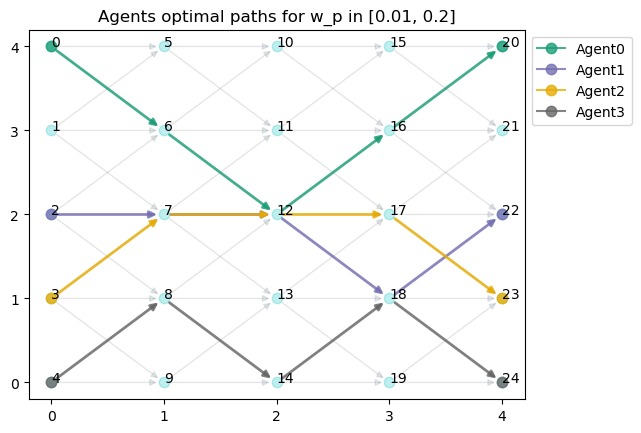

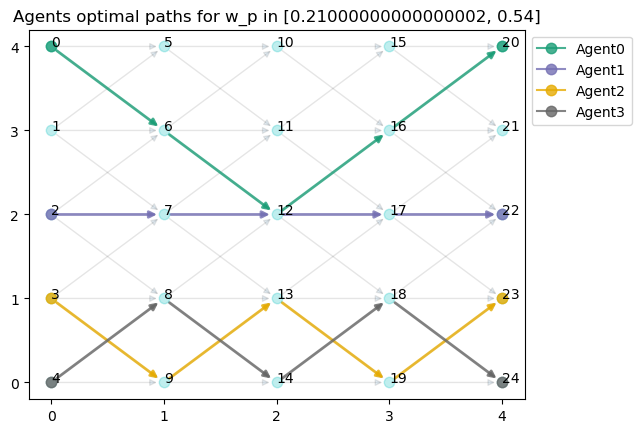

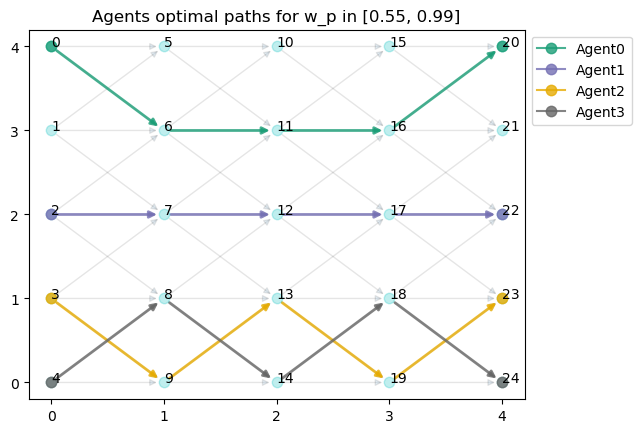

In [21]:
for x_opt, w_p_interval in zip(opt_solutions, w_p_intervals):
    dv.plot_solution(x_opt, nodes_grid, w_arcs, agents,
                     title=f"Agents optimal paths for w_p in [{w_p_interval[0]}, {w_p_interval[1]}]")

Notice that the solution reported in the article for $w_p\in[0.01, 0.2]$ (Fig. 5) is diferent from what we found.  
However our solution is still an optimal solution, as can be seen in `pareto_results_df`, since it has the same total distance and penalty (therefore same total objective value) of the paper's solution
